In [10]:
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from pathlib import Path

In [12]:
from zod import ZodDataset, ZodFrame, ZodFrames
from zod import AnnotationProject

dataset_fold

In [13]:
dataset_dir = "single_frames"
log_id = "007674"

log_dir = Path(dataset_dir) / log_id
assert log_dir.exists(), f"Log directory {log_dir} does not exist."

In [14]:
# load one log dir
def load_log_data(log_id):
    frames = ZodFrames(".", version="mini")
    frame = frames[log_id]
    
    image = frame.get_image()
    obj_list = frame.get_annotation(AnnotationProject.OBJECT_DETECTION)
    ts_list = frame.get_annotation(AnnotationProject.TRAFFIC_SIGNS)
    lm_list = frame.get_annotation(AnnotationProject.LANE_MARKINGS)
    
    oxts = frame.oxts
    
    return {
        "image": image,
        "obj_list": obj_list,
        "ts_list": ts_list,
        "lm_list": lm_list,
        "oxts": oxts,
    }

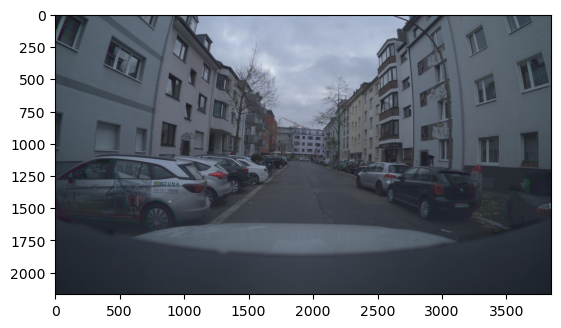

In [15]:
log_data = load_log_data(log_id)
plt.imshow(log_data["image"])

In [19]:
def plot_objs_on_image(image, obj_list):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for obj in obj_list:
        bbox = obj.box2d.xyxy  # numpy array: [x1, y1, x2, y2]
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color="red",
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            bbox[1],
            getattr(obj, "object_type", getattr(obj, "category", "")),
            color="yellow",
            fontsize=12,
            backgroundcolor="black",
        )
    ax.axis("off")
    fig.tight_layout(pad=0)
    # Return the figure or the numpy array of the image with bboxes
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img_with_boxes = np.frombuffer(fig.canvas.get_renderer().buffer_rgba(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape((height, width, 4))[:, :, :3]  # 去掉alpha通道
    plt.close(fig)
    return img_with_boxes

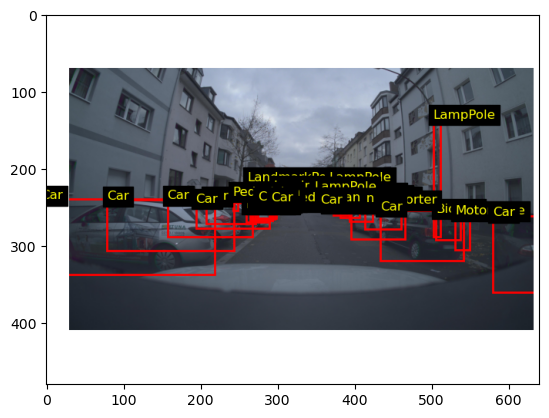

In [21]:
image_objs = plot_objs_on_image(log_data["image"], log_data["obj_list"])
plt.imshow(image_objs)

In [28]:
log_data["ts_list"][0].traffic_sign_class   

'NotListed'

In [26]:
def plot_traffic_signs_on_image(image, ts_list):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for ts in ts_list:
        bbox = ts.bounding_box.xyxy  # numpy array: [x1, y1, x2, y2]
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color="blue",
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            bbox[1],
            getattr(ts, "sign_type", ""),
            color="yellow",
            fontsize=12,
            backgroundcolor="black",
        )
    ax.axis("off")
    fig.tight_layout(pad=0)
    # Return the figure or the numpy array of the image with bboxes
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img_with_boxes = np.frombuffer(fig.canvas.get_renderer().buffer_rgba(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape((height, width, 4))[:, :, :3]  # 去掉alpha通道
    plt.close(fig)
    return img_with_boxes

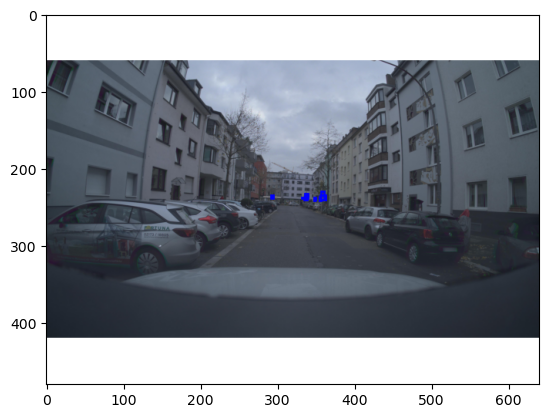

In [27]:
image_ts = plot_traffic_signs_on_image(log_data["image"], log_data["ts_list"])
plt.imshow(image_ts)

In [32]:
# get lon lat

oxts = log_data["oxts"]
lat, lon = oxts.origin_lat_lon

In [34]:
# show lat lon on map
import folium
m = folium.Map(location=[lat, lon], zoom_start=15)
folium.Marker([lat, lon], popup="Origin").add_to(m)
m

# Retrieval Mapillary Images using GNSS info

In [35]:
import requests

In [ ]:
mapillary_api = "MLY|6692561254169237|2772cc746cac47d32f5b8bbc767ed462"
